# Task 3

# Imports

In [141]:
import numpy as np
import pandas as pd
from joblib import dump, load

from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from pathlib import Path
import s3fs
import sys

plt.style.use('dark_background')
plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'normal', 'figure.figsize': (8, 6)})

In [67]:
# make sure root dir is added to sys.path for our imports from /src and reading files to work
root_name = 'rainfall_group22'
p_root = Path.cwd()

while not p_root.name == root_name:
    p_root = p_root.parent

sys.path.append(str(p_root))
print('p_root:', p_root)

# need to be in the cloned repo to import our custom functions
from src import sklearn_helper_funcs as sf

bucket = 's3://mds-s3-student19'

aws_credentials = pd \
    .read_csv(p_root / 'student19_accessKeys.csv') \
    .iloc[0].to_dict()

p_root: /Users/Jayme/OneDrive/MDS/525/rainfall_group22


## Part 1:

Recall as a final goal of this project. We want to build and deploy ensemble machine learning models in the cloud, where features are outputs of different climate models and the target is the actual rainfall observation. In this milestone, you'll actually build these ensemble machine learning models in the cloud.  

**Your tasks:**

1. Read the data CSV from your s3 bucket. 
2. Drop rows with nans. 
3. Split the data into train (80%) and test (20%) portions with `random_state=123`. 
4. Carry out EDA of your choice on the train split. 
5. Train ensemble machine learning model using `RandomForestRegressor` and evaluate with metric of your choice (e.g., `RMSE`) by considering `Observed` as the target column. 
6. Discuss your results. Are you getting better results with ensemble models compared to the individual climate models? 

> Recall that individual columns in the data are predictions of different climate models. 

In [53]:
# read data from milestone2 from s3
df = pd.read_csv(
        f'{bucket}/output/ml_data_SYD.csv',
        index_col=0,
        parse_dates=True,
        storage_options=aws_credentials) \
    .dropna() \
    .pipe(sf.lower_cols)

df_orig = df.copy()
df

,access_cm2,access_esm1_5,awi_esm_1_1_lr,bcc_csm2_mr,bcc_esm1,cmcc_cm2_hr4,cmcc_cm2_sr5,cmcc_esm2,can_esm5,ec_earth3_veg_lr,...,mpi_esm_1_2_ham,mpi_esm1_2_hr,mpi_esm1_2_lr,mri_esm2_0,nesm3,nor_esm2_lm,nor_esm2_mm,sam0_unicon,tai_esm1,observed_rain
time,,,,,,,,,,,,,,,,,,,,,
1889-01-01,0.040427,1.814552,3.557934e+01,4.268112e+00,1.107466e-03,1.141054e+01,3.322009e-08,2.668800,1.321215,1.515293,...,4.244226e-13,1.390174e-13,6.537884e-05,3.445495e-06,1.576096e+01,4.759651e-05,2.451075,0.221324,2.257933,0.006612
1889-01-02,0.073777,0.303965,4.596520e+00,1.190141e+00,1.015323e-04,4.014984e+00,1.312700e+00,0.946211,2.788724,4.771375,...,4.409552e+00,1.222283e-01,1.049131e-13,4.791993e-09,3.675510e-01,4.350863e-01,0.477231,3.757179,2.287381,0.090422
1889-01-03,0.232656,0.019976,5.927467e+00,1.003845e-09,1.760345e-05,9.660565e+00,9.103720e+00,0.431999,0.003672,4.233980,...,2.269300e-01,3.762301e-01,9.758706e-14,6.912302e-01,1.562869e-01,9.561101e+00,0.023083,0.253357,1.199909,1.401452
1889-01-04,0.911319,13.623777,8.029624e+00,8.225225e-02,1.808932e-01,3.951528e+00,1.317160e+01,0.368693,0.013578,15.252495,...,2.344586e-02,4.214019e-01,7.060915e-03,3.835721e-02,2.472226e-07,5.301038e-01,0.002699,2.185454,2.106737,14.869798
1889-01-05,0.698013,0.021048,2.132686e+00,2.496841e+00,4.708019e-09,2.766362e+00,1.822940e+01,0.339267,0.002468,11.920356,...,4.270161e-13,1.879692e-01,4.504985e+00,3.506923e-07,1.949792e-13,1.460928e-10,0.001026,2.766507,1.763335,0.467628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,0.033748,0.123476,1.451179e+00,3.852845e+01,2.061717e-03,8.179260e-09,1.171263e-02,0.090786,59.895053,5.071783,...,4.726998e-13,1.326889e-01,1.827857e+00,6.912632e-03,2.171327e-03,1.620489e+00,2.084252,0.868046,17.444923,0.037472
2014-12-28,0.094198,2.645496,4.249335e+01,5.833801e-01,5.939502e-09,8.146937e-01,4.938899e-01,0.000000,0.512632,1.578188,...,4.609420e-13,1.644482e+00,7.242920e-01,2.836752e-03,1.344768e+01,2.391159e+00,1.644527,0.782258,1.569647,0.158061
2014-12-29,0.005964,3.041667,2.898325e+00,9.359547e-02,2.000051e-08,2.532205e-01,1.306046e+00,0.000002,37.169669,1.565885,...,2.016156e+01,1.506439e+00,1.049481e-01,8.137182e+00,2.547820e+01,1.987695e-12,0.205036,2.140723,1.444630,0.025719


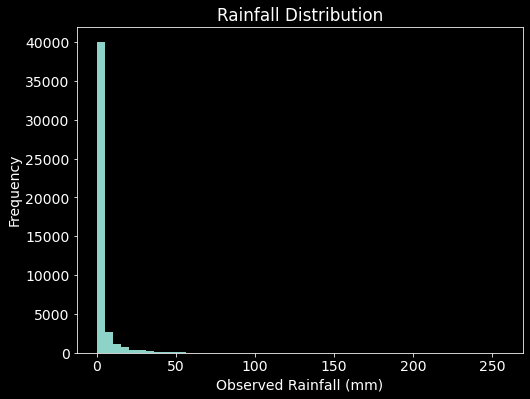

In [140]:
# rainfall hist
ax = df.observed_rain.plot(
    kind='hist',
    bins=50,
    title='Rainfall Distribution')

ax.set(xlabel='Observed Rainfall (mm)');

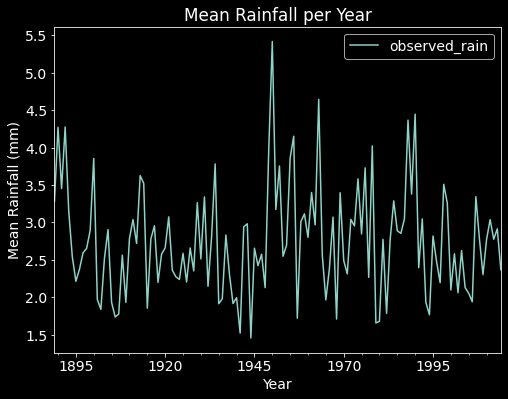

In [139]:
# show mean rainfall per year
df[['observed_rain']].groupby(pd.Grouper(freq='Y')) \
    .mean() \
    .plot(
        title='Mean Rainfall per Year',
        xlabel='Year',
        ylabel='Mean Rainfall (mm)');

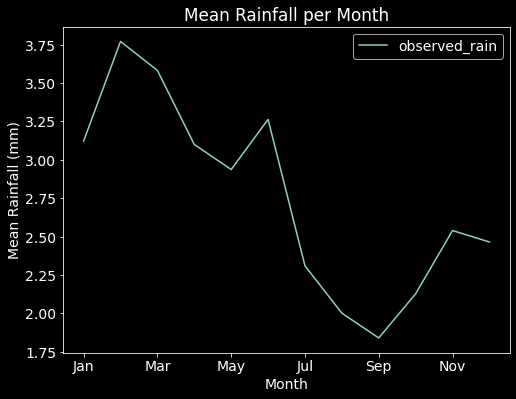

In [133]:
df.observed_rain.groupby(lambda x: x.month) \
    .mean() \
    .rename_axis('month') \
    .reset_index() \
    .assign(month=lambda x: x.month.apply(lambda x: calendar.month_abbr[x])) \
    .set_index('month') \
    .plot(
        title='Mean Rainfall per Month',
        xlabel='Month',
        ylabel='Mean Rainfall (mm)');

In [80]:
target = 'observed_rain'

features = dict(
    target=[target])

features['numeric'] = sf.all_except(df, features.values())

encoders = dict(
    numeric=Pipeline(
        steps=[
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', MinMaxScaler(feature_range=(0, 1)))]))
            
smape_scorer = make_scorer(sf.smape, greater_is_better=False)
scoring = dict(
    rmse='neg_root_mean_squared_error',
    mape=smape_scorer)

cv_args = dict(cv=5, n_jobs=-2, return_train_score=True, scoring=scoring)

mm = sf.ModelManager(
    scoring=scoring,
    cv_args=cv_args,
    features=features,
    encoders=encoders,
    random_state=123)

x_train, y_train, x_test, y_test = mm.make_train_test(df, target=target, train_size=0.8)

mm.show_ct()

(36791, 25)


,count,mean,std,min,25%,50%,75%,max
access_cm2,36791.0,0.016200,0.045286,0.0,3.608006e-04,0.001287,0.009638,1.0
access_esm1_5,36791.0,0.018648,0.044724,0.0,1.348192e-04,0.003127,0.015219,1.0
awi_esm_1_1_lr,36791.0,0.041539,0.081382,0.0,3.310527e-04,0.006621,0.040258,1.0
bcc_csm2_mr,36791.0,0.016384,0.048475,0.0,3.785304e-06,0.000717,0.009809,1.0
bcc_esm1,36791.0,0.031542,0.068830,0.0,2.733692e-05,0.003427,0.028437,1.0
cmcc_cm2_hr4,36791.0,0.024752,0.051694,0.0,1.106945e-03,0.005070,0.025471,1.0
cmcc_cm2_sr5,36791.0,0.025510,0.052469,0.0,6.349959e-04,0.005907,0.026598,1.0
cmcc_esm2,36791.0,0.025363,0.051160,0.0,6.738174e-04,0.006168,0.026382,1.0
can_esm5,36791.0,0.021239,0.050888,0.0,1.659178e-04,0.002490,0.018875,1.0
ec_earth3_veg_lr,36791.0,0.026606,0.059454,0.0,1.246196e-04,0.004456,0.023810,1.0


In [81]:
# LGBMRegressor gives better results and trains much faster, will use lgbm going forward

models = dict(
    rnd=RandomForestRegressor(max_depth=3, n_estimators=50),
    lgbm=LGBMRegressor(max_depth=3, n_estimators=50))

mm.cross_val(models=models, lower_better=True)

,fit_time,score_time,test_rmse,train_rmse,test_mape,train_mape,std_test_rmse,std_train_rmse,std_test_mape,std_train_mape
rnd,5.997,0.013,8.096,7.969,1.493,1.493,0.434,0.097,0.009,0.002
lgbm,0.248,0.015,8.075,7.961,1.492,1.489,0.385,0.101,0.009,0.002


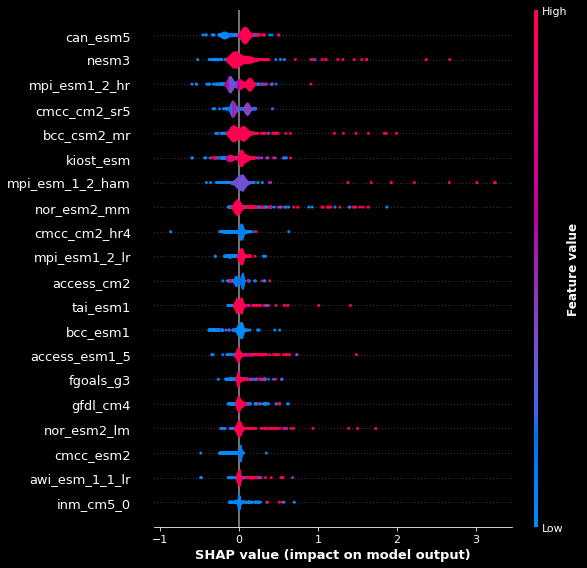

In [82]:
mm.shap_plot('lgbm')

In [168]:
# compare RMSE of each individual model vs ensemble
model = models['lgbm']
model.fit(x_train, y_train)

df_test = mm.df_test.copy()
df_test['lgbm_ensemble'] = model.predict(x_test)

m_rmse = {}

for col in df_test.drop(columns=[target]).columns:
    m_rmse[col] = mean_squared_error(
        y_pred=df_test[col].values,
        y_true=df_test.observed_rain.values,
        squared=False)

pd.DataFrame \
    .from_dict(m_rmse, orient='index', columns=['RMSE']) \
    .rename_axis('model') \
    .sort_values('RMSE') \
    .style \
    .pipe(sf.bg, rev=False) \
    .format('{:.3f}')

,RMSE
model,
lgbm_ensemble,8.624
kiost_esm,9.600
fgoals_g3,9.688
mri_esm2_0,9.923
mpi_esm1_2_hr,9.970
nesm3,9.978
mpi_esm1_2_lr,10.261
nor_esm2_lm,10.410
ec_earth3_veg_lr,10.454


- The ensemble model seems to have ~20% better scores than the mean of all individual models.

## Part 2:

### Preparation for deploying model next week

#### Complete task 4 from the milestone3 before coming here

We’ve found ```n_estimators=100, max_depth=5``` to be the best hyperparameter settings with MLlib (from the task 4 from milestone3), here we then use the same hyperparameters to train a scikit-learn model. 

In [164]:
# using lgbm model from previous step (faster and better scores)

# model = RandomForestRegressor(n_estimators=100, max_depth=20)
# model.fit(x_train, y_train.values.ravel())

RandomForestRegressor(max_depth=20)

In [169]:
print(f'Train RMSE: {mean_squared_error(y_train, model.predict(x_train), squared=False):.2f}')
print(f'Test RMSE: {mean_squared_error(y_test, model.predict(x_test), squared=False):.2f}')

Train RMSE: 7.98
 Test RMSE: 8.62


In [167]:
# ready to deploy
model_name = 'model.joblib'
dump(model, model_name)

['model.joblib']

***Upload model.joblib to s3. You choose how you want to upload it.***

In [170]:
import subprocess
source = p_root / model_name
args = ['aws', 's3' , 'cp', str(source), f'{bucket}/{model_name}']
subprocess.run(args)

CompletedProcess(args=['aws', 's3', 'cp', '/Users/Jayme/OneDrive/MDS/525/rainfall_group22/model.joblib', 's3://mds-s3-student19/model.joblib'], returncode=0)